# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./train.p"
testing_file = "./test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    

train_features, train_labels = train['features'], train['labels']
test_features, test_labels = test['features'], test['labels']
print("Data loaded :)")

Data loaded :)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(train_features)

# TODO: Number of testing examples.
n_test = len(test_features)

# TODO: What's the shape of an traffic sign image?
image_shape = train_features[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(train_labels))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


# Visualization 

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

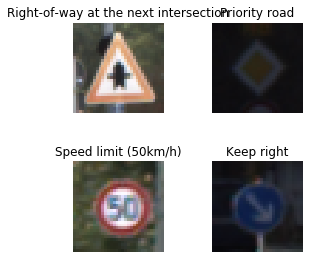

In [3]:
### Data exploration visualization goes here.
import matplotlib.pyplot as plt
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

#load label text function
def load_label_file(file):
    lines = open(file).readlines()[1:]
    lines = [line.strip().split(",") for line in lines]
    label_descs = dict([ (int(classid), desc) for classid, desc in lines])
    return label_descs

label_descriptions = load_label_file("signnames.csv")


#select samples from training data
n_samples = 4
isample = np.random.randint(0, n_train, n_samples)
sample_imgs = train_features[isample]
sample_labels = list(map(label_descriptions.get, train_labels[isample]))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(2*2, 2*2))
axes = axes.ravel()
fig.tight_layout()

for ax, img, label in zip(axes, sample_imgs, sample_labels):
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

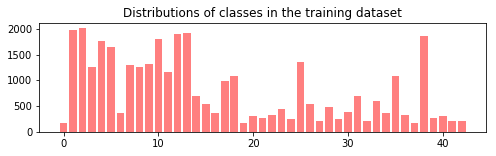

In [4]:
#lets look at the distributions of classes in the dataset
train_classes = np.bincount(train_labels)
plt.figure(figsize=(8, 2))
plt.bar(range(n_classes), train_classes, label="train", color="r", alpha=0.5)
plt.title("Distributions of classes in the training dataset")

[STATE] Turning to YUV space:
YUV images


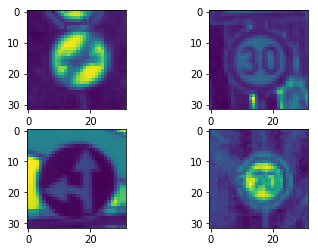

In [5]:
import cv2
print('[STATE] Turning to YUV space:')

def preprocess_yuvspace(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,0] for img in images])

yuv = preprocess_yuvspace(train_features)

# Plot four sample images
print('YUV images')
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(yuv[i*2500+1])

## Preprocess the Data

In [6]:
#import packages
import scipy.ndimage
from sklearn import cross_validation

yuv = train_features
inputs_per_class = np.bincount(train_labels)
max_inputs = np.max(inputs_per_class)

# Generate additional data for underrepresented classes
print('[STATE] Generating additional data:')
angles = [-30, 30, -60, 60, -90, 90, -120, 120]

for i in range(len(inputs_per_class)):
    input_ratio = min(int(max_inputs / inputs_per_class[i]) - 1, len(angles) - 1)

    if input_ratio <= 1:
        continue

    new_features = []
    new_labels = []
    mask = np.where(train_labels == i)

    for j in range(input_ratio):
        for feature in train_features[mask]:
            new_features.append(scipy.ndimage.rotate(feature, angles[j], reshape=False))
            new_labels.append(i)

    train_features = np.append(train_features, new_features, axis=0)
    train_labels = np.append(train_labels, new_labels, axis=0)



# Get randomized datasets for training and validation
print('[STATE] Randomizing:')
train_features, valid_features, train_labels, valid_labels = cross_validation.train_test_split(
   train_features,
   train_labels,
   test_size=0.2,
   random_state=832289
)

print('Data preprocessed')

/Applications/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[STATE] Generating additional data:
[STATE] Randomizing:
Data preprocessed


In [7]:
n_train = len(train_features)
print("Number of training examples before =", n_train)

X_train, X_validation, y_train, y_validation = cross_validation.train_test_split(train_features, train_labels, test_size=0.2, random_state=7)
n_train = len(X_train)
val = len(X_validation)


print("Number of training examples after =", n_train)
print("Number of validation examples =", val)
print("Sum of both = ", val + n_train)

X_test = test_features
y_test = test_labels

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

Number of training examples before = 55509
Number of training examples after = 44407
Number of validation examples = 11102
Sum of both =  55509


## Step 2: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the German Traffic Sign Dataset.
The LeNet-5 implementation shown in the classroom at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!
With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission.
There are various aspects to consider when thinking about this problem:
Neural network architecture (is the network over or underfitting?)
Play around preprocessing techniques (normalization, rgb to grayscale, etc)
Number of examples per label (some have more than others).
Generate fake data.
Here is an example of a published baseline model on this problem. It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

In [25]:
### Train your model here.
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128

In [26]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [27]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
target_output = one_hot_y


In [28]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = target_output)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [29]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [30]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.587

EPOCH 2 ...
Validation Accuracy = 0.754

EPOCH 3 ...
Validation Accuracy = 0.833

EPOCH 4 ...
Validation Accuracy = 0.866

EPOCH 5 ...
Validation Accuracy = 0.891

EPOCH 6 ...
Validation Accuracy = 0.900

EPOCH 7 ...
Validation Accuracy = 0.912

EPOCH 8 ...
Validation Accuracy = 0.922

EPOCH 9 ...
Validation Accuracy = 0.918

EPOCH 10 ...
Validation Accuracy = 0.937

Model saved


In [31]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.832


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

In [33]:
# Pick 10 random images
import random

images32 = [skimage.transform.resize(image, (32, 32))
                for image in images]
display_images_and_labels(logits, images)


sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

NameError: name 'images' is not defined